#Understanding the Objective
#The goal is to predict whether the salary for data-related positions, based on location, company reviews, and job title, is satisfactory or not.
هدف:
در این پروژه یک مجموعه داده از حقوق مشاغل مختلف که با داده سروکار دارن (مثل دیتا ساینتیست، تحلیلگر داده و ...) در ایالت‌های مختلف آمریکا داریم و مبلغ حقوق به اینکه کدوم ایالته، بقیه در مورد شرکت چی گفتن، و اینکه عنوان دقیق شغل چیه و... بستگی داره. حالا هدف ما اینه که بفهمیم (پیش‌بینی کنیم) حقوق این مشاغل مناسبه یا نه.



#Import dataset

In [103]:
#from google.colab import files # For use in google colab

In [104]:
#uploaded = files.upload()  # For use in google colab

#Import Libraries

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_absolute_error
import pickle

#Read the data

In [108]:
df_raw = pd.read_csv('df_salary_estimat.csv')

# Data Understanding

In [110]:
df_raw.head()

,Job Title,Salary Estimate,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),3.5,Hopper\n3.5,"New York, NY",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),4.5,Noom US\n4.5,"New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable
2,Data Science Manager,$111K-$181K (Glassdoor est.),-1.0,Decode_M,"New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable
3,Data Analyst,$111K-$181K (Glassdoor est.),3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable
4,"Director, Data Science",$111K-$181K (Glassdoor est.),3.4,United Entertainment Group\n3.4,"New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable


Looking at this data, a few things come to mind:

We can group job titles based on the words they contain, such as "Data Science" "Data Scientist" and so on.
We can extract the minimum and maximum salaries from the "Salary Estimate" column, average them out, and use that as our "average salary" - this will be our target variable.
I don't think the company names will have a significant impact.
We can determine the state where each position is located from the "Location" column.
Given the numerous unknowns in the "Revenue" column, we will not use that column in our analysis.

وقتی به این داده نگاه می‌کنیم، چند تا چیز به چشم می‌خوره:
ما می‌تونیم عناوین شغلیو براساس کلماتی که در اونها وجود داره دسته بندی کنیم: مثلاً همه کارهایی که تو اسمشون کلمه 
"Data Scientist" یا "Data Science"
هست رو بذاریم یه جا.
کمترین و بیشترین حقوق رو از اون ستون 
"Salary Estimate"
استخراج کنیم، میانگین بگیریم و بگیم که این، حقوق متوسط کارهاست. و در نهایت این متغیر هدف ما خواهد بود.
فکر نکنم اسم شرکت‌ها خیلی فرقی داشته باشه.
از ستون 
"Location"
می‌تونیم بفهمیم هر کار کجا انجام میشه.
ستون 
"Revenue"
خیلی اطلاعاتش دقیق نیست، پس فعلاً کاری بهش نداریم

#Assess data

In [113]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5892 entries, 0 to 5891
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          5892 non-null   object 
 1   Salary Estimate    5892 non-null   object 
 2   Rating             5892 non-null   float64
 3   Company Name       5892 non-null   object 
 4   Location           5892 non-null   object 
 5   Size               5892 non-null   object 
 6   Founded            5892 non-null   object 
 7   Type of ownership  5892 non-null   object 
 8   Industry           5892 non-null   object 
 9   Sector             5892 non-null   object 
 10  Revenue            5892 non-null   object 
dtypes: float64(1), object(10)
memory usage: 506.5+ KB


#Clean Data


In [115]:
  # Remove instances without salary estimates
  df = df_raw[df_raw['Salary Estimate'] != '-1']

In [116]:
 # Remove Per Hour salary
df = df[~df['Salary Estimate'].str.contains('Per Hour')]

In [117]:
  # Remove $
  df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.replace('$', ' '))

In [118]:
  # Remove K
df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.replace('K', ' '))

In [119]:
#Split it
df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.split())

In [120]:
df['Min_salary'] = df['Salary Estimate'].apply(lambda x: x[0])
df['Max_salary'] = df['Salary Estimate'].apply(lambda x: x[2])

In [121]:
  # Cast Min_salary and Max_salary to int and get the avrage salary
df['Min_salary'] = df['Min_salary'].apply(lambda x:int(x))
df['Max_salary']=df['Max_salary'].astype(int)
df['Average_salary'] = (df.Min_salary + df.Max_salary)/2

In [163]:
# State: what state is the job in
df['State'] = df['Location'].apply(lambda x: x.split()[-1])
                                   
# remove United Kingdom
df = df[df.State != 'Kingdom'] 

In [164]:
def classify_titles(x):
        """
        This function organizes the job title
        """
        x = x.lower()
        if ('data scientist' in x) or ('data science' in x) :
            return 'data scientist'
        elif 'data engineer' in x:
            return 'data engineer'
        elif 'deep learning' in x:
            return 'deep learning engineer'
        elif 'machine learning' in x:
            return 'machine learning engineer'
        elif 'director' in x:
            return 'director'
        elif 'manager' in x:
            return 'manager'
        elif 'analyst' in x:
            return 'analyst'
        elif 'researcher' in x:
            return 'researcher'
        else:
            return 'other'

In [165]:
df['Job Title'] = df['Job Title'].apply(classify_titles)

In [166]:
# Remove instances without rating
df = df[df['Rating']!=-1]

In [167]:
cleaned_df = df[['Job Title', 'Rating', 'Average_salary', 'State']]

In [168]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4891 entries, 0 to 5887
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Job Title       4891 non-null   object 
 1   Rating          4891 non-null   float64
 2   Average_salary  4891 non-null   float64
 3   State           4891 non-null   object 
dtypes: float64(2), object(2)
memory usage: 191.1+ KB


#Exploratory Data Analysis (EDA)

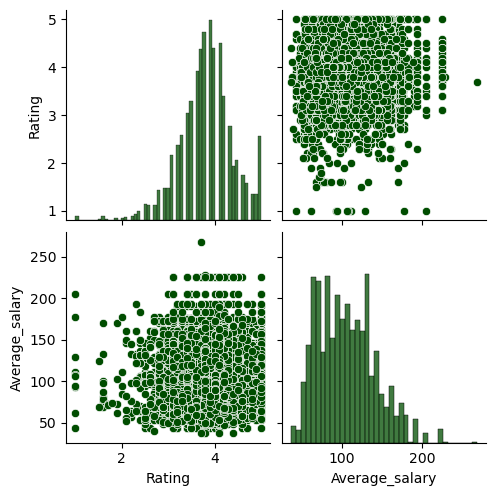

In [298]:
sns.pairplot(cleaned_df)
sns.set_palette(['#004d00'])
plt.show()

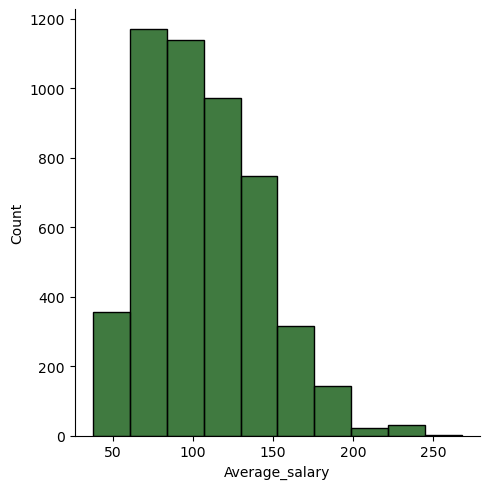

In [296]:
sns.displot(x='Average_salary', data= cleaned_df, bins = 10, color='#004d00') 
plt.show()

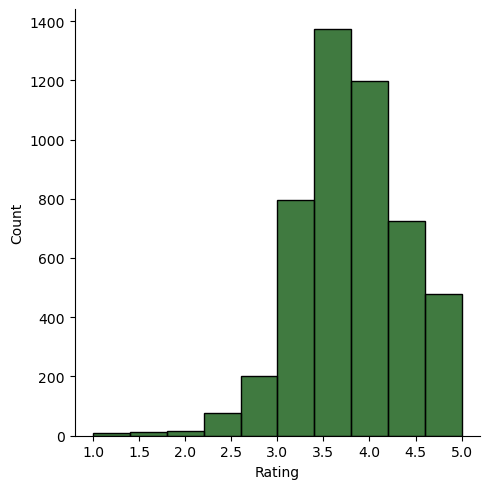

In [306]:
sns.displot(x='Rating', data= cleaned_df, bins = 10, color='#004d00')
plt.show()

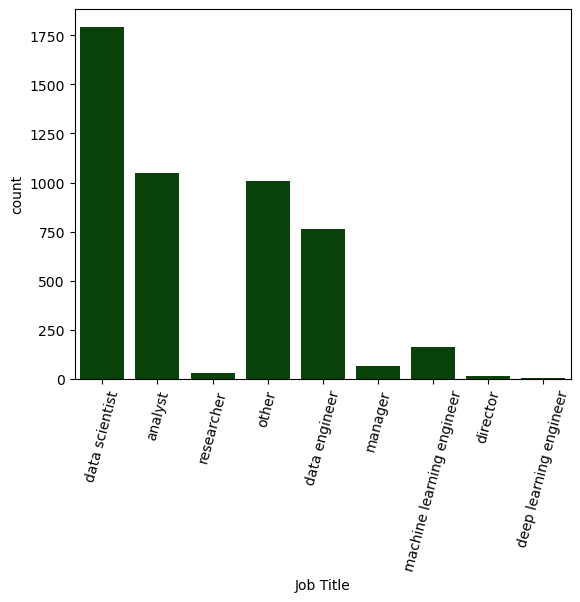

In [310]:
sns.countplot(x='Job Title', data= cleaned_df, color='#004d00')
plt.xticks(rotation= 75)
plt.show()

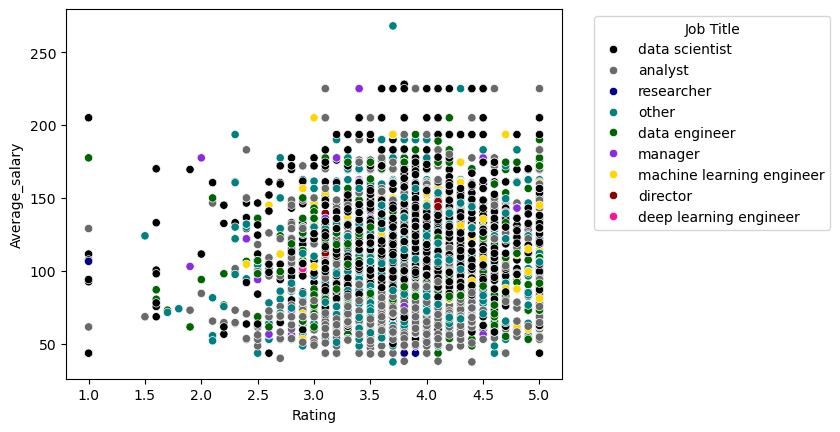

In [312]:
custom_palette = {'data scientist':'#000000', 'analyst':'#696969', 'researcher':'#000080','other':'#008080','data engineer':'#006400', 
                 'manager':'#8A2BE2', 'machine learning engineer':'#FFD700', 'director':'#8B0000', 'deep learning engineer':'#FF1493'}
sns.scatterplot(x='Rating', y='Average_salary', data= cleaned_df, hue='Job Title', palette=custom_palette)
plt.legend(title='Job Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Feature Engineering

In [176]:
preprocessed_df = pd.get_dummies(cleaned_df, columns=['Job Title','State'])

In [177]:
preprocessed_df

,Rating,Average_salary,Job Title_analyst,Job Title_data engineer,Job Title_data scientist,Job Title_deep learning engineer,Job Title_director,Job Title_machine learning engineer,Job Title_manager,Job Title_other,...,State_NC,State_NH,State_NJ,State_NM,State_NY,State_OH,State_PA,State_TX,State_VA,State_WI
0,3.5,146.0,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,4.5,146.0,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,3.4,146.0,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,3.4,146.0,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
5,2.9,146.0,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5881,3.2,51.0,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
5882,4.2,68.0,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
5883,4.0,89.5,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
5886,4.0,89.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [178]:
preprocessed_df['Average_salary'].median()


102.0

In [179]:
def Satisfy(x):
  if x>= 102:
    return(1)
  else:
    return(0)

In [180]:
preprocessed_df['Satisfaction'] = preprocessed_df['Average_salary'].apply(Satisfy)

In [181]:
preprocessed_df['Satisfaction']

0       1
1       1
3       1
4       1
5       1
       ..
5881    0
5882    0
5883    0
5886    0
5887    0
Name: Satisfaction, Length: 4891, dtype: int64

In [182]:
preprocessed_df[['Average_salary', 'Satisfaction']]

,Average_salary,Satisfaction
0,146.0,1
1,146.0,1
3,146.0,1
4,146.0,1
5,146.0,1
...,...,...
5881,51.0,0
5882,68.0,0
5883,89.5,0
5886,89.0,0


In [183]:
  X = preprocessed_df.drop(columns=['Average_salary', 'Satisfaction'])

In [184]:
y = preprocessed_df['Satisfaction']

# Modeling

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)

In [187]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression  

In [188]:
logreg = LogisticRegression()

In [189]:
logreg.fit(X_train,y_train)

LogisticRegression()

In [190]:
prediction = logreg.predict(X_test)

In [191]:
prediction

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [192]:
y_test

4607    0
3136    1
2694    0
4633    0
4490    1
       ..
5366    0
2080    0
3348    0
1996    0
4704    1
Name: Satisfaction, Length: 1468, dtype: int64

In [193]:
from sklearn.metrics import confusion_matrix

In [194]:
confusion_matrix(y_test,prediction)

array([[517, 205],
       [230, 516]], dtype=int64)

In [195]:
len(y_test)

1468

In [197]:
from sklearn.metrics import classification_report

In [198]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70       722
           1       0.72      0.69      0.70       746

    accuracy                           0.70      1468
   macro avg       0.70      0.70      0.70      1468
weighted avg       0.70      0.70      0.70      1468



In [199]:
from sklearn.metrics import accuracy_score

In [200]:
accuracy_score(y_test, prediction)

0.7036784741144414

In [201]:
# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier

In [202]:
knn = KNeighborsClassifier()

In [203]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [204]:
prediction_knn = knn.predict(X_test)

In [205]:
prediction_knn

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [206]:
y_test

4607    0
3136    1
2694    0
4633    0
4490    1
       ..
5366    0
2080    0
3348    0
1996    0
4704    1
Name: Satisfaction, Length: 1468, dtype: int64

In [207]:
confusion_matrix(y_test, prediction_knn)

array([[462, 260],
       [250, 496]], dtype=int64)

In [208]:
accuracy_score(y_test, prediction_knn)

0.6525885558583107

In [209]:
print(classification_report(y_test, prediction_knn))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       722
           1       0.66      0.66      0.66       746

    accuracy                           0.65      1468
   macro avg       0.65      0.65      0.65      1468
weighted avg       0.65      0.65      0.65      1468



# Decision Tree classification algorithm


1.   List item
2.   List item



In [211]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [212]:
tree = DecisionTreeClassifier()

In [213]:
tree.fit(X_train , y_train)

DecisionTreeClassifier()

In [214]:
predict_tree = tree.predict(X_test)

In [215]:
predict_tree

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [216]:
y_test

4607    0
3136    1
2694    0
4633    0
4490    1
       ..
5366    0
2080    0
3348    0
1996    0
4704    1
Name: Satisfaction, Length: 1468, dtype: int64

In [217]:
confusion_matrix(y_test,predict_tree)

array([[507, 215],
       [281, 465]], dtype=int64)

In [218]:
accuracy_score(y_test,predict_tree)

0.662125340599455

In [219]:
print(classification_report(y_test,predict_tree))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       722
           1       0.68      0.62      0.65       746

    accuracy                           0.66      1468
   macro avg       0.66      0.66      0.66      1468
weighted avg       0.66      0.66      0.66      1468



# Random Forest classification algorithm


In [221]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [222]:
rf = RandomForestClassifier()

In [223]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [224]:
predict_rf = rf.predict(X_test)

In [225]:
predict_rf

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [226]:
y_test

4607    0
3136    1
2694    0
4633    0
4490    1
       ..
5366    0
2080    0
3348    0
1996    0
4704    1
Name: Satisfaction, Length: 1468, dtype: int64

In [227]:
confusion_matrix(y_test, predict_rf)

array([[467, 255],
       [251, 495]], dtype=int64)

In [228]:
accuracy_score(y_test, predict_rf)

0.6553133514986376

In [229]:
print(classification_report(y_test, predict_rf))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       722
           1       0.66      0.66      0.66       746

    accuracy                           0.66      1468
   macro avg       0.66      0.66      0.66      1468
weighted avg       0.66      0.66      0.66      1468

